Global Best Fitness: 363.9091591183942
Final Centroids:
[[-8.80032661  7.02920624]
 [-6.7626914  -6.86916157]
 [-2.73866467  8.95529401]
 [ 4.62147781  2.09540251]]


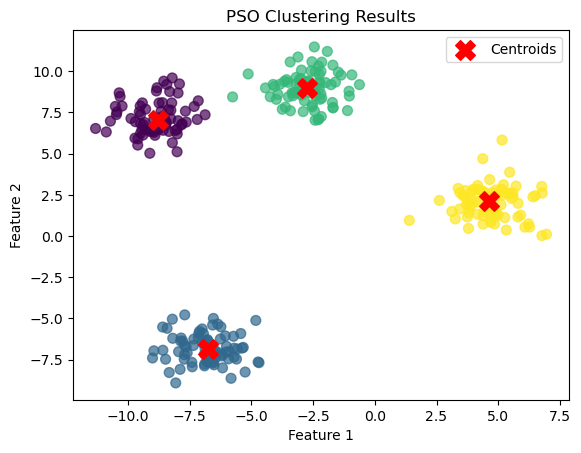

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

class Particle:
    def __init__(self, n_clusters, n_features, data_min, data_max):
        # Position represents the cluster centroids
        self.position = np.random.uniform(data_min, data_max, (n_clusters, n_features))
        self.velocity = np.random.uniform(-1, 1, (n_clusters, n_features))
        self.best_position = np.copy(self.position)
        self.best_fitness = float('inf')

class PSOClustering:
    def __init__(self, data, n_clusters, n_particles=30, max_iter=100, w=0.7, c1=1.5, c2=1.5):
        self.data = data
        self.n_clusters = n_clusters
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive component (personal best)
        self.c2 = c2  # Social component (global best)

        self.n_features = data.shape[1]
        self.data_min = np.min(data, axis=0)
        self.data_max = np.max(data, axis=0)

        self.particles = [Particle(n_clusters, self.n_features, self.data_min, self.data_max) for _ in range(n_particles)]
        self.global_best_position = None
        self.global_best_fitness = float('inf')

    def _calculate_fitness(self, centroids):
        """Calculates the sum of squared distances for a given set of centroids."""
        labels, distances = pairwise_distances_argmin_min(self.data, centroids)
        return np.sum(distances)

    def run(self):
        for _ in range(self.max_iter):
            for particle in self.particles:
                # Calculate fitness for current position
                current_fitness = self._calculate_fitness(particle.position)

                # Update personal best
                if current_fitness < particle.best_fitness:
                    particle.best_fitness = current_fitness
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if current_fitness < self.global_best_fitness:
                    self.global_best_fitness = current_fitness
                    self.global_best_position = np.copy(particle.position)

            # Update particle velocities and positions
            for particle in self.particles:
                r1 = np.random.rand(self.n_clusters, self.n_features)
                r2 = np.random.rand(self.n_clusters, self.n_features)

                cognitive_component = self.c1 * r1 * (particle.best_position - particle.position)
                social_component = self.c2 * r2 * (self.global_best_position - particle.position)

                particle.velocity = self.w * particle.velocity + cognitive_component + social_component
                particle.position += particle.velocity

                # Ensure centroids stay within data bounds (optional but can help stability)
                particle.position = np.clip(particle.position, self.data_min, self.data_max)

        # Assign final clusters based on the global best centroids
        final_labels, _ = pairwise_distances_argmin_min(self.data, self.global_best_position)
        return final_labels, self.global_best_position, self.global_best_fitness

# Example Usage:
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    import matplotlib.pyplot as plt

    # Generate sample data
    X, _ = make_blobs(n_samples=300, centers=4, random_state=42)

    # Initialize and run PSO clustering
    pso_clustering = PSOClustering(data=X, n_clusters=4, n_particles=50, max_iter=200)
    labels, centroids, fitness = pso_clustering.run()

    print(f"Global Best Fitness: {fitness}")
    print(f"Final Centroids:\n{centroids}")

    # Visualize the results
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title("PSO Clustering Results")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()